In [340]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.tsa import stattools
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


## 1. Clean Data

In [341]:
df = pd.read_csv("ECA_blended_custom/TG_STAID002759.txt" ,skiprows=19, index_col=1, parse_dates=True, skipinitialspace=True)

In [342]:
df['SOUID'].unique()

array([127488, 128124, 111448])

127488,BERLIN-DAHLEM (LFAG)

128124,BERLIN-TREPTOW

111448,BERLIN-TEMPELHOF


In [343]:
df.head(2)

SOUID  TG  Q_TG
DATE                        
1876-01-01  127488  22     0
1876-01-02  127488  25     0

### Check the missing data

In [344]:
df[df['TG'] == -9999]

SOUID    TG  Q_TG
DATE                          
1945-04-25  127488 -9999     9
1945-04-26  127488 -9999     9
1945-04-27  127488 -9999     9
1945-04-28  127488 -9999     9
1945-04-29  127488 -9999     9
...            ...   ...   ...
1945-11-01  127488 -9999     9
1945-11-02  127488 -9999     9
1945-11-03  127488 -9999     9
1945-11-04  127488 -9999     9
1945-11-05  127488 -9999     9

[195 rows x 3 columns]

### Define the method to replace the missing data by using the average of data from 5 years further and after

In [345]:
def find_mean(date):
    temps = []
    # dates = []
    for i in range(5):
        d_minus = date - pd.DateOffset(years=i+1)
        d_plus = date + pd.DateOffset(years=i+1)
        temp_minus = df.loc[d_minus]['TG']
        temp_plus = df.loc[d_plus]['TG']
        # dates.extend([d_minus, d_plus])
        temps.extend([temp_minus, temp_plus])
    # print(dates)
    # print(temps)
    return sum(temps) / len(temps)

### test funciton

In [346]:
date = pd.to_datetime('1945-04-25')

In [347]:
find_mean(date)

112.2

### Apply function to Dataset

In [348]:
for i, j in df['TG'].items():
    if j == -9999:
        temp = find_mean(i)
        df.at[i,'TG'] = temp

### Check again the missing data

In [349]:
len(df[df['TG'] == -9999])

0

### Create new column for temperature and drop unnecessary columns

In [350]:
df['TEMP'] = df['TG']/10

In [351]:
df.drop(['SOUID', 'TG', 'Q_TG'], axis=1, inplace=True)

In [352]:
df.head()

TEMP
DATE            
1876-01-01   2.2
1876-01-02   2.5
1876-01-03   0.3
1876-01-04  -5.8
1876-01-05  -9.8

In [353]:
df.to_csv('clean_temp.csv')

# ----------------- clean_temp.csv -----------------

## 2. Split Data into Trainset and Testset

In [354]:
df = pd.read_csv('clean_temp.csv', parse_dates=True, index_col=0)

In [355]:
df_train = df[:'2020']

In [356]:
df_test = df['2021':]

In [357]:
df_test.head(2)

TEMP
DATE            
2021-01-01   2.1
2021-01-02   1.1

### Plot

<AxesSubplot: xlabel='DATE'>

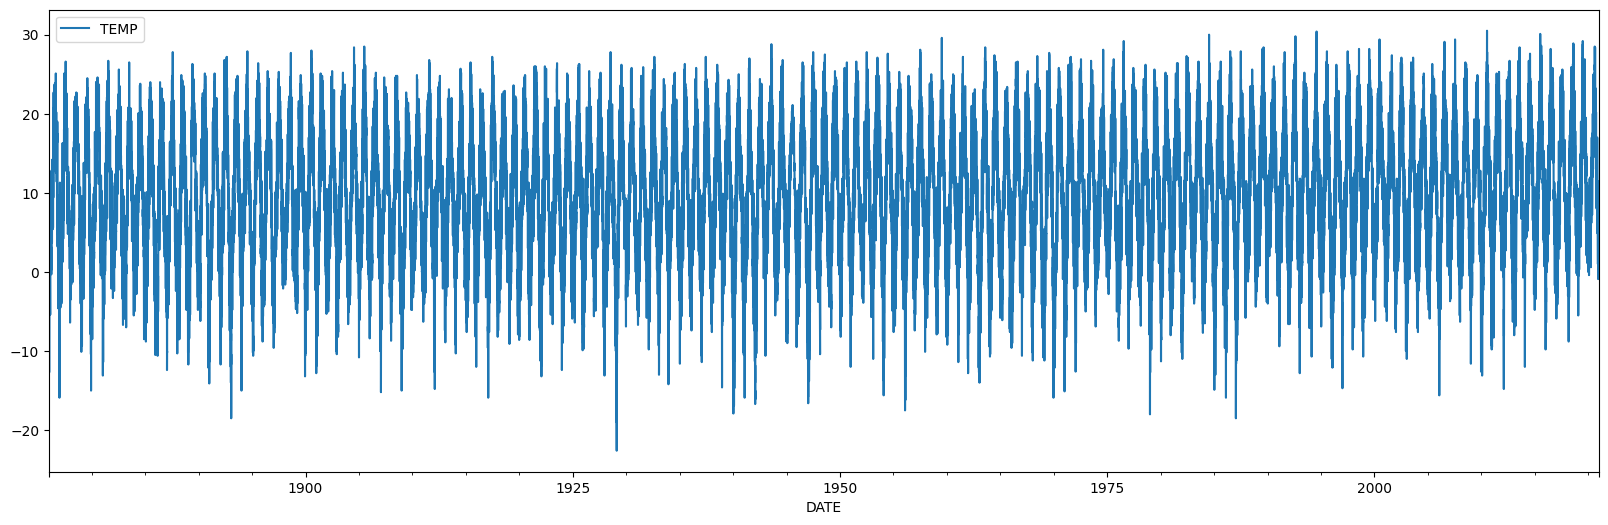

In [358]:
df_train.plot(figsize=(20,6))

<AxesSubplot: xlabel='DATE'>

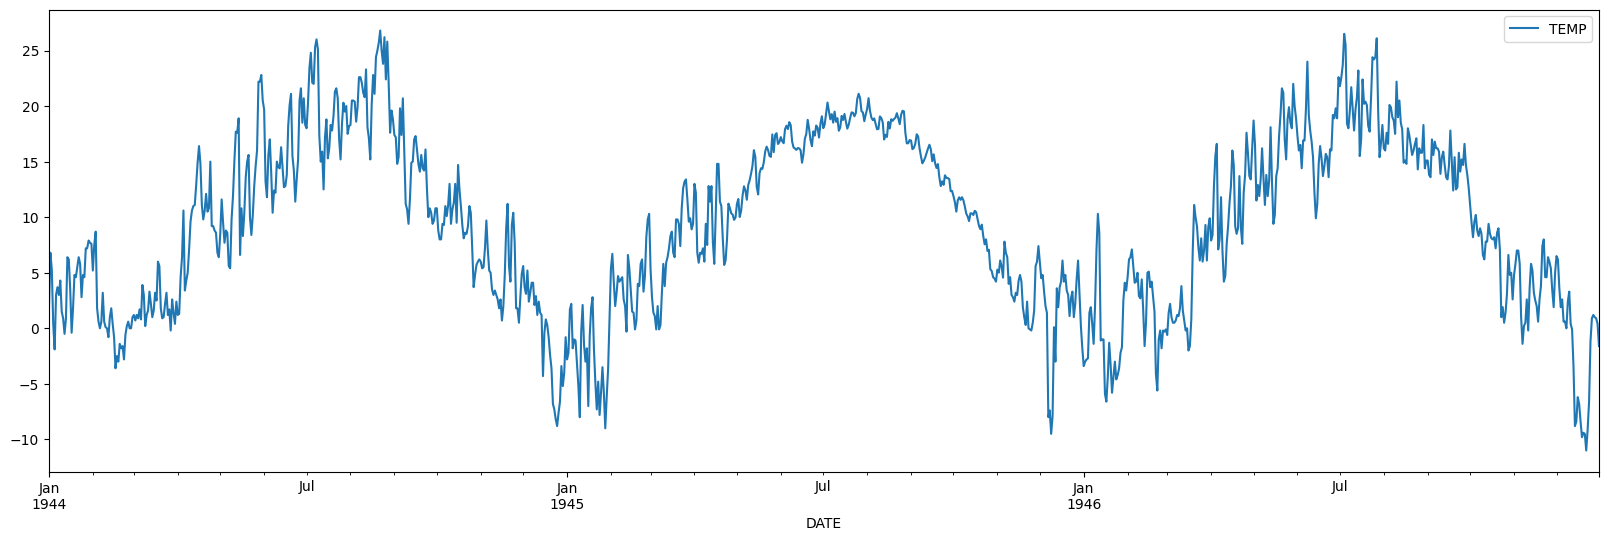

In [359]:
df_train['1944':'1946'].plot(figsize=(20,6))

## 3. Trend

In [360]:
df_train['timestep'] = range(len(df_train))

In [361]:
X = df_train[['timestep']]
y = df_train['TEMP']
from sklearn.linear_model import LinearRegression

In [362]:
m_trend = LinearRegression()
m_trend.fit(X,y)

LinearRegression()

In [363]:
df_train['trend'] = m_trend.predict(X)
df_train['trend'].head(2)

DATE
1876-01-01    8.527227
1876-01-02    8.527260
Name: trend, dtype: float64

<AxesSubplot: xlabel='DATE'>

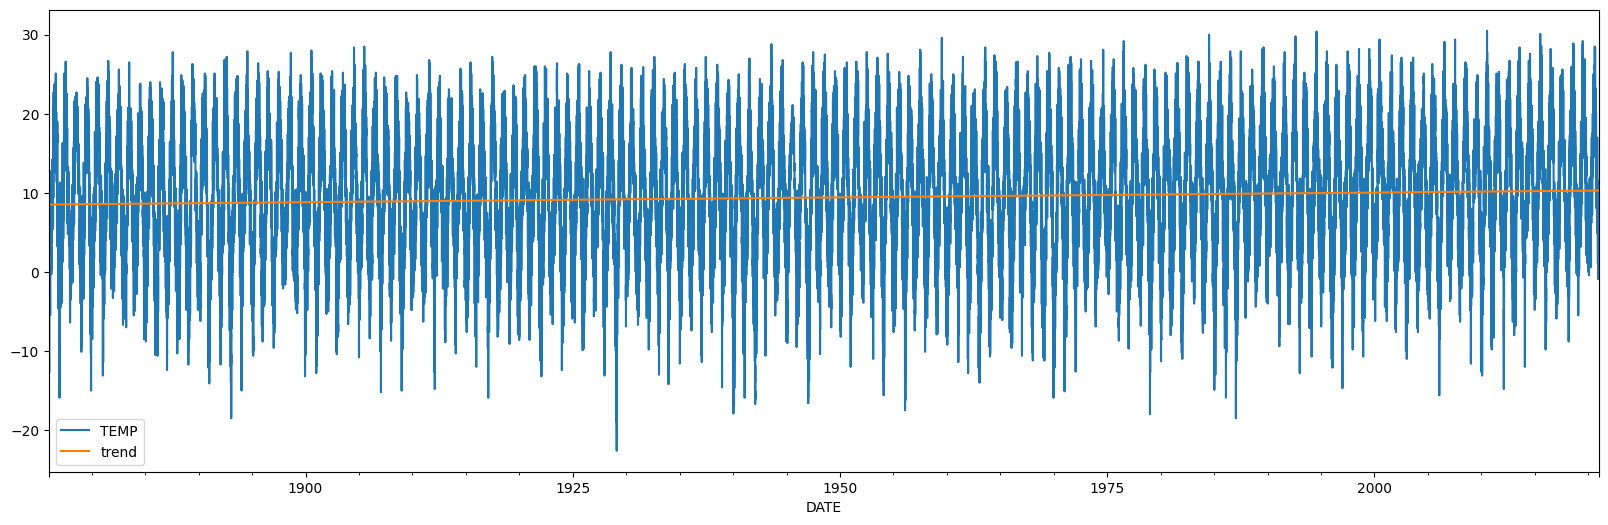

In [364]:
df_train[['TEMP','trend']].plot(figsize=(20,6))

In [365]:
m_trend.intercept_,m_trend.coef_

(8.527226962521784, array([3.33509484e-05]))

In [366]:
df_train.head(2)

TEMP  timestep     trend
DATE                                
1876-01-01   2.2         0  8.527227
1876-01-02   2.5         1  8.527260

## 4. Seasonality

<AxesSubplot: xlabel='DATE'>

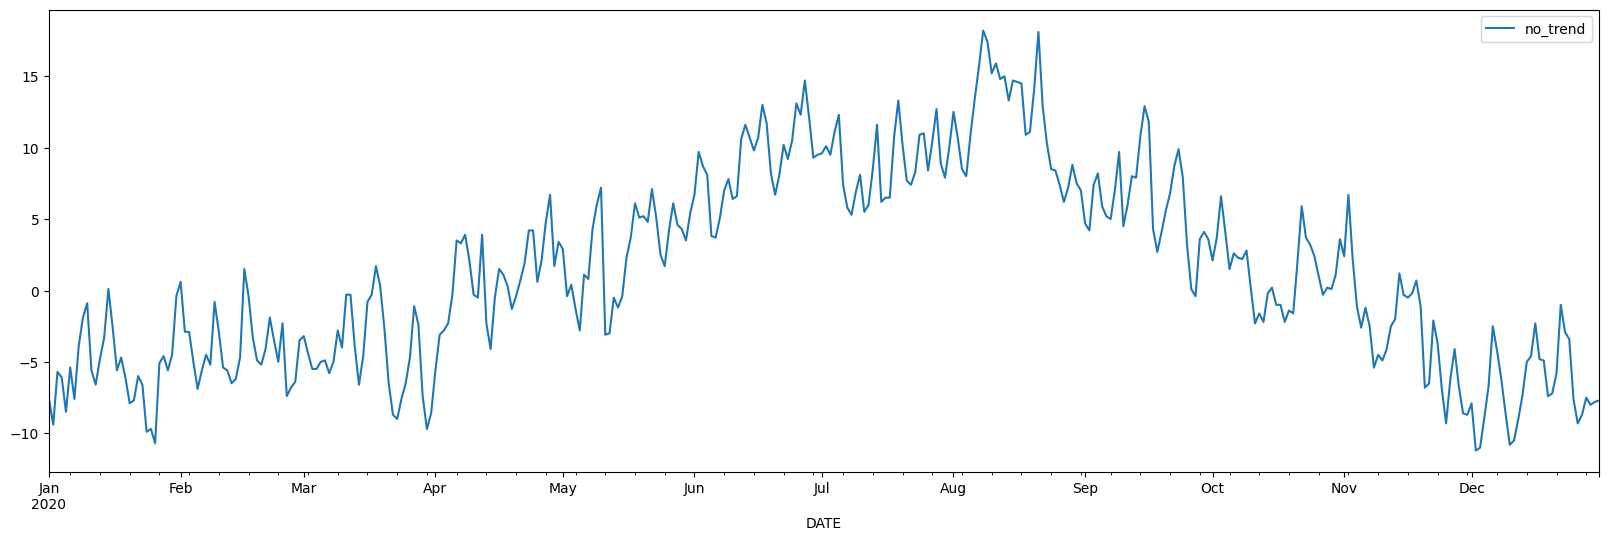

In [367]:
df_train['no_trend'] = df_train['TEMP'] - df_train['trend']
df_train['2020-01-01':'2020-12-31'][['no_trend']].plot(figsize=(20,6))

<AxesSubplot: xlabel='DATE'>

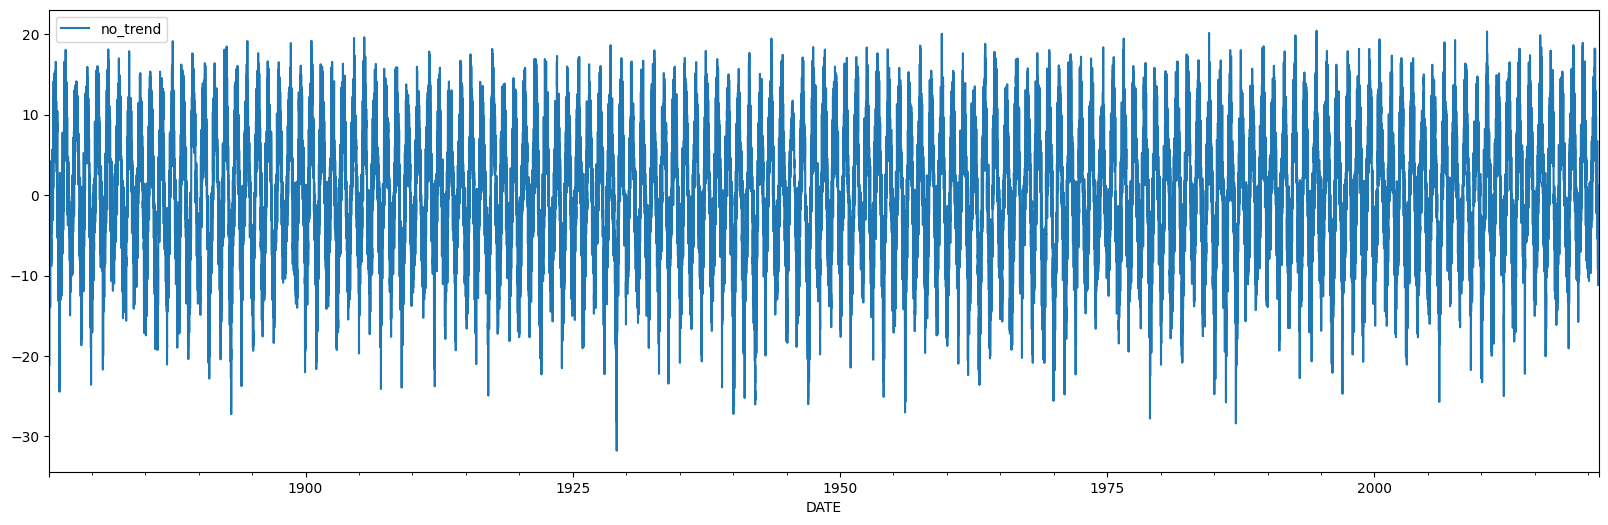

In [368]:
df_train[['no_trend']].plot(figsize=(20,6))

### 4.1 take day of year as seasonal feature

In [369]:
df_train['day_of_year_sin'] = np.sin(2 * np.pi * df_train.index.day_of_year/365.0)
df_train['day_of_year_cos'] = np.cos(2 * np.pi * df_train.index.day_of_year/365.0)

In [370]:
df_train.head(2)

TEMP  timestep     trend  no_trend  day_of_year_sin  \
DATE                                                              
1876-01-01   2.2         0  8.527227 -6.327227         0.017213   
1876-01-02   2.5         1  8.527260 -6.027260         0.034422   

            day_of_year_cos  
DATE                         
1876-01-01         0.999852  
1876-01-02         0.999407

In [371]:
from sklearn.linear_model import LinearRegression
m_trend_seasonal_day = LinearRegression()
X = df_train[['timestep', 'day_of_year_sin', 'day_of_year_cos']]
y = df_train['TEMP']
m_trend_seasonal_day.fit(X, y)
df_train['trend_seasonal_day'] = m_trend_seasonal_day.predict(X)

<AxesSubplot: xlabel='DATE'>

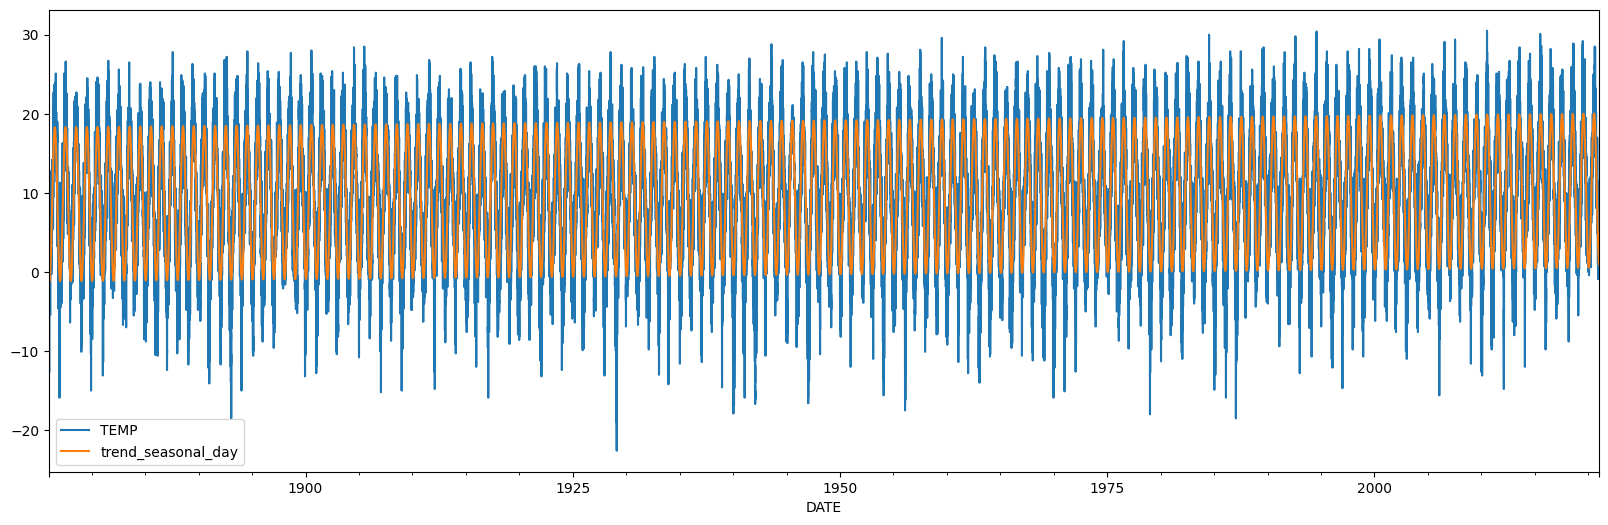

In [372]:
df_train[['TEMP','trend_seasonal_day']].plot(figsize=(20,6))

<AxesSubplot: xlabel='DATE'>

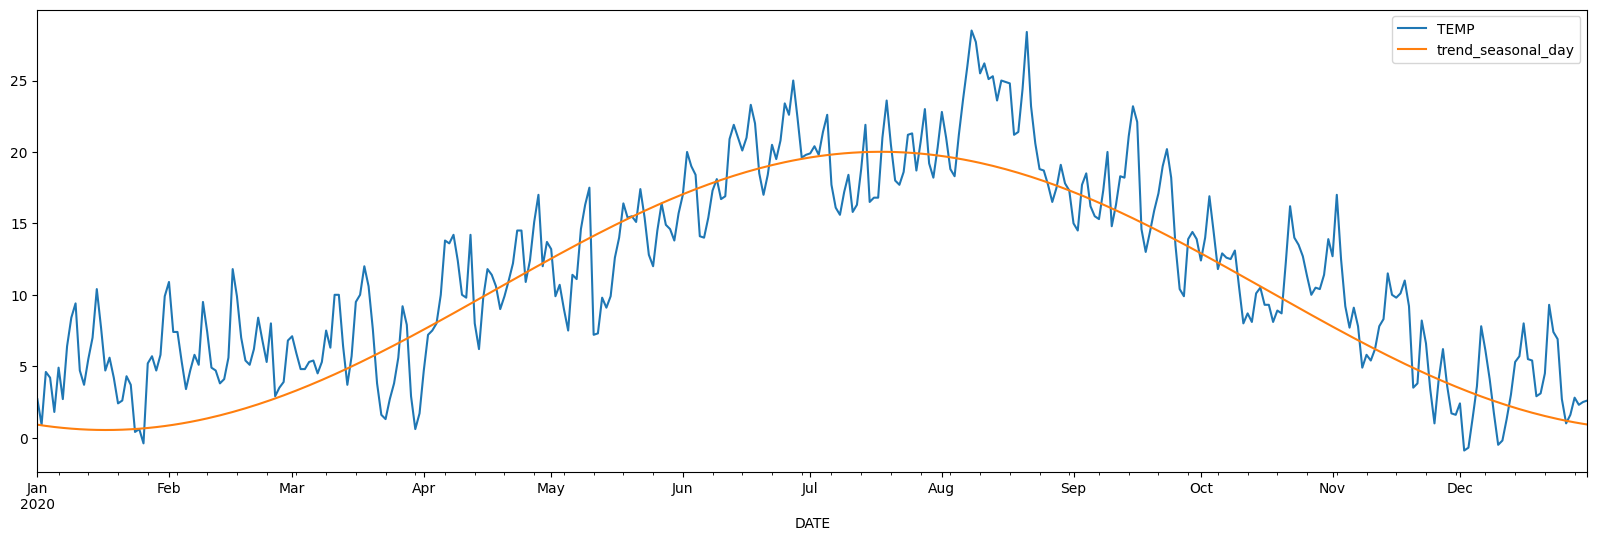

In [373]:
df_train['2020-01-01':'2020-12-31'][['TEMP','trend_seasonal_day']].plot(figsize=(20,6))

### 4.2 take month as seasonal feature

In [374]:
df_train['month_sin'] = np.sin(2 * np.pi * df_train.index.month/12.0)
df_train['month_cos'] = np.cos(2 * np.pi * df_train.index.month/12.0)

In [375]:
from sklearn.linear_model import LinearRegression
m_trend_seasonal_month = LinearRegression()
X = df_train[['timestep', 'month_sin', 'month_cos']]
y = df_train['TEMP']
m_trend_seasonal_month.fit(X, y)
df_train['trend_seasonal_month'] = m_trend_seasonal_month.predict(X)

<AxesSubplot: xlabel='DATE'>

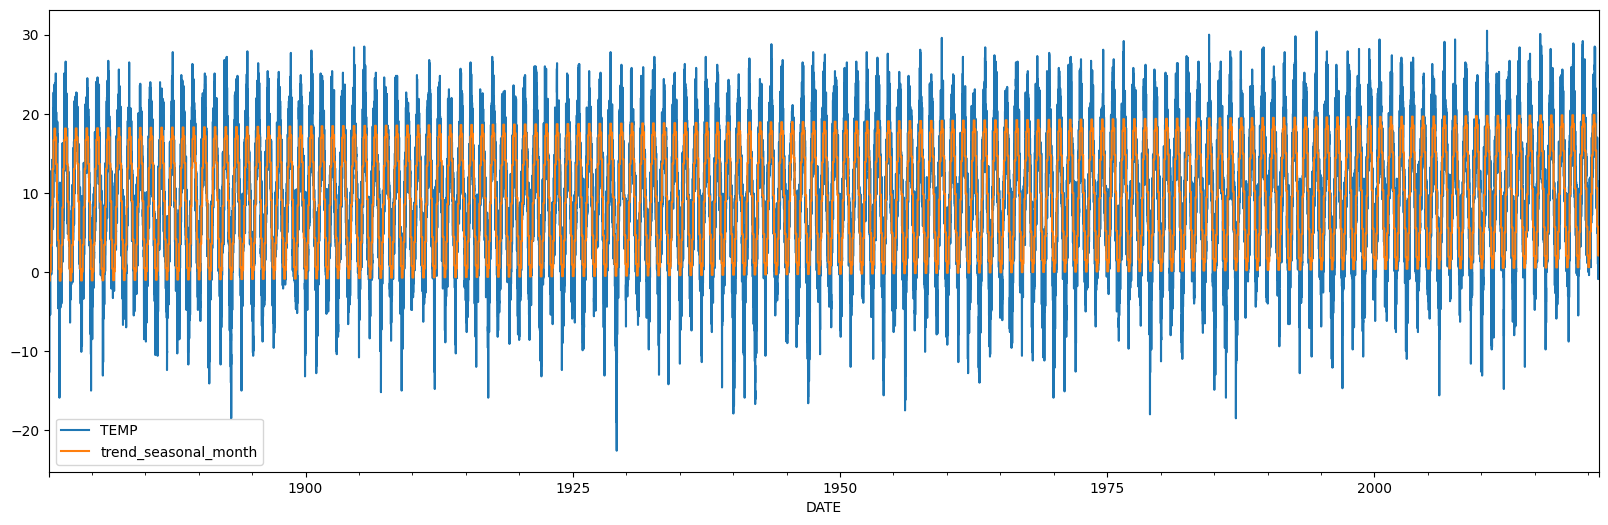

In [376]:
df_train[['TEMP','trend_seasonal_month']].plot(figsize=(20,6))

<AxesSubplot: xlabel='DATE'>

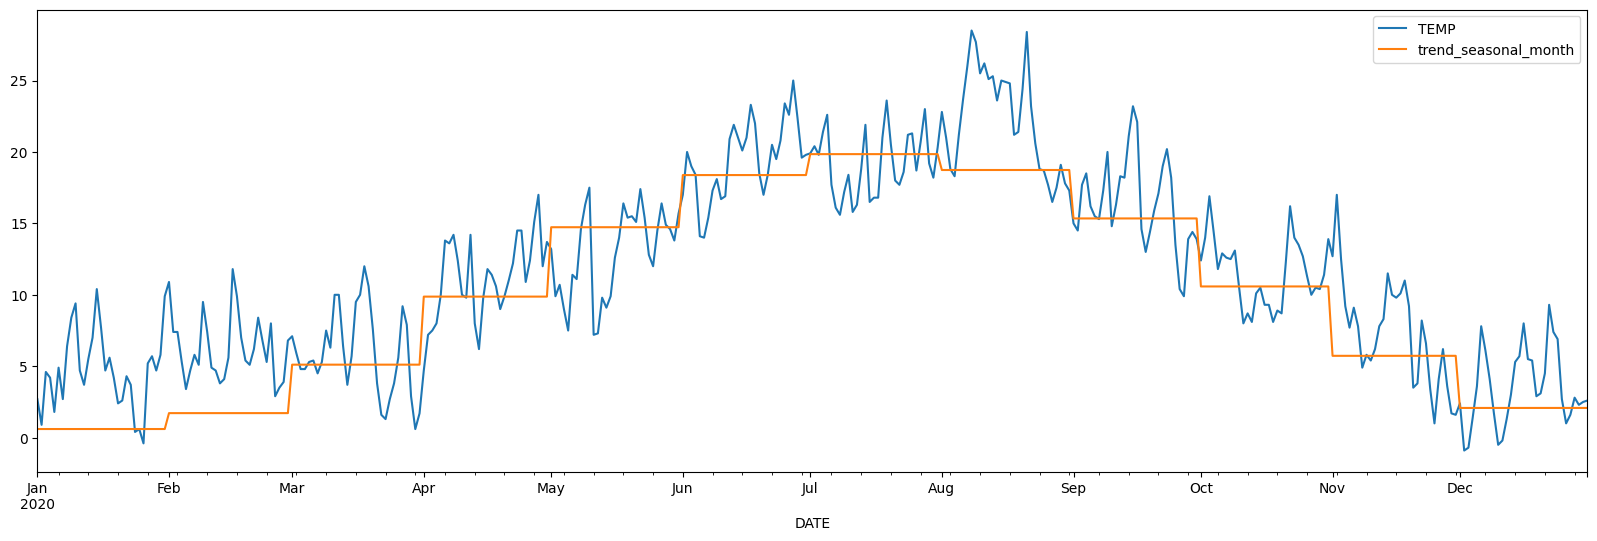

In [377]:
df_train['2020-01-01':'2020-12-31'][['TEMP','trend_seasonal_month']].plot(figsize=(20,6))

In [378]:
# X['month'] = X.index.month
# month_dummies = pd.get_dummies(X['month'],prefix='month_',drop_first=True)
# X = df[['timestep']]
# X = X.join(month_dummies)
# m = LinearRegression()
# m.fit(X1,y)
# X_df = df[['TEMP']]
# X_df['pred'] = m.predict(X1)
# X_df[['TEMP','pred']][df.index >= pd.Timestamp(2020,1,1)].plot()

In [379]:
df_train.head(2)

TEMP  timestep     trend  no_trend  day_of_year_sin  \
DATE                                                              
1876-01-01   2.2         0  8.527227 -6.327227         0.017213   
1876-01-02   2.5         1  8.527260 -6.027260         0.034422   

            day_of_year_cos  trend_seasonal_day  month_sin  month_cos  \
DATE                                                                    
1876-01-01         0.999852           -0.810634        0.5   0.866025   
1876-01-02         0.999407           -0.855106        0.5   0.866025   

            trend_seasonal_month  
DATE                              
1876-01-01             -1.114660  
1876-01-02             -1.114627

## 5. Remainder: take day of the year as seasonality

In [380]:
df_train['remainder'] = df_train['TEMP'] - df_train['trend_seasonal_day']


### check remainder using adf

In [381]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """)

In [382]:
print_adf(df_train['remainder'])

adf_stats: -37.956192389968024
            p: 0.0 
            number of observations: 52939
            CI 99%: -3.4304735311794756
            CI 95%: -2.861594598311134
            CI 90%: -2.5667990608636555
            information criterion (AIC): 234902.25617357908
            


<AxesSubplot: xlabel='DATE'>

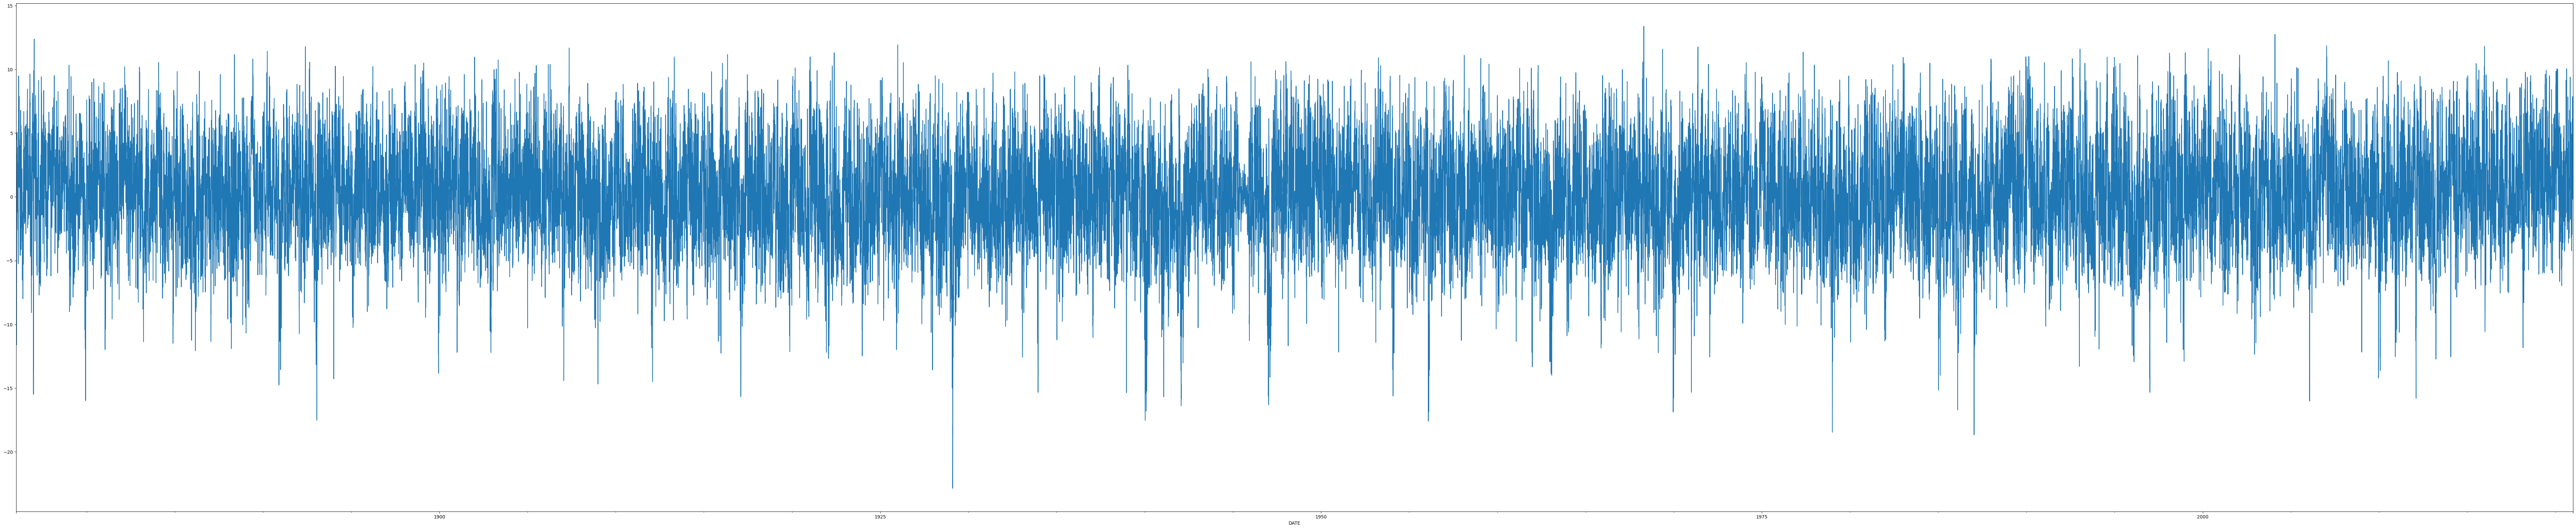

In [383]:
df_train['remainder'].plot(figsize=(100, 20))

<AxesSubplot: xlabel='DATE'>

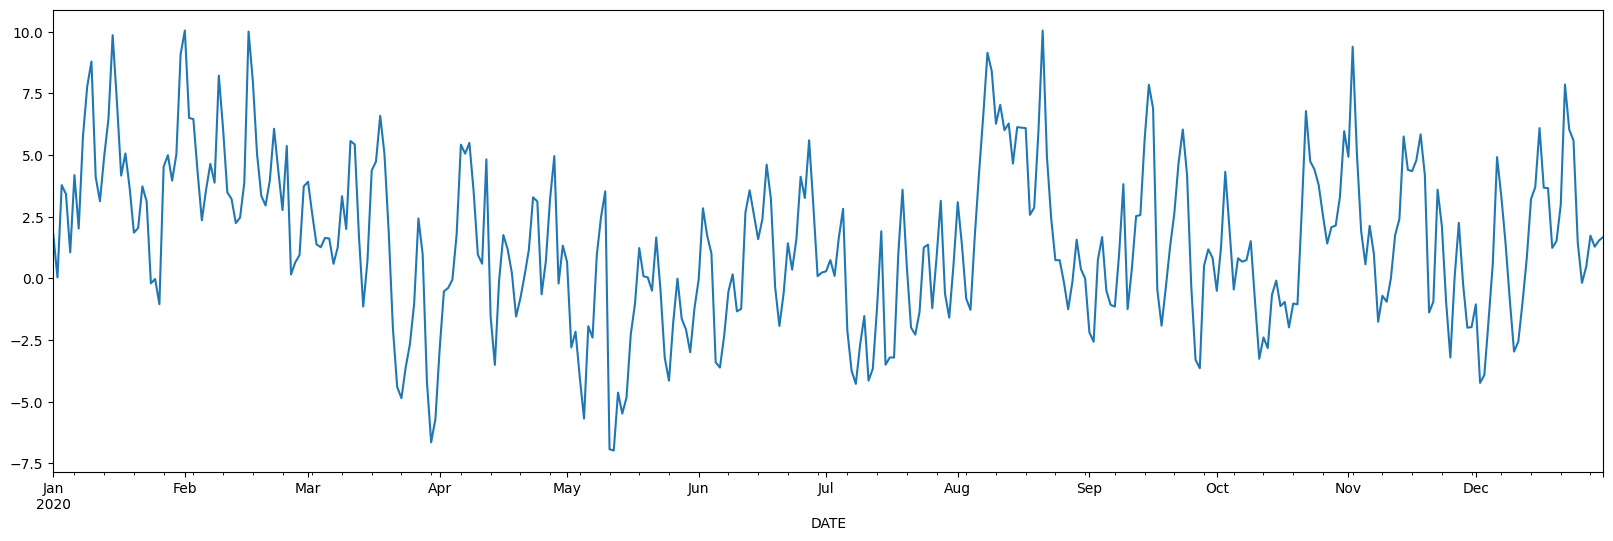

In [384]:
df_train['2020-01-01':'2020-12-31']['remainder'].plot(figsize=(20, 6))

In [385]:
# save remainder as csv
df_train.remainder.to_csv('temp_remainder.csv')

## 6. Autoregressive Model

In [386]:
df_re = pd.read_csv("temp_remainder.csv").set_index('DATE')
df_re.head(1)

remainder
DATE                 
1876-01-01   3.010634

(-0.05, 0.05)

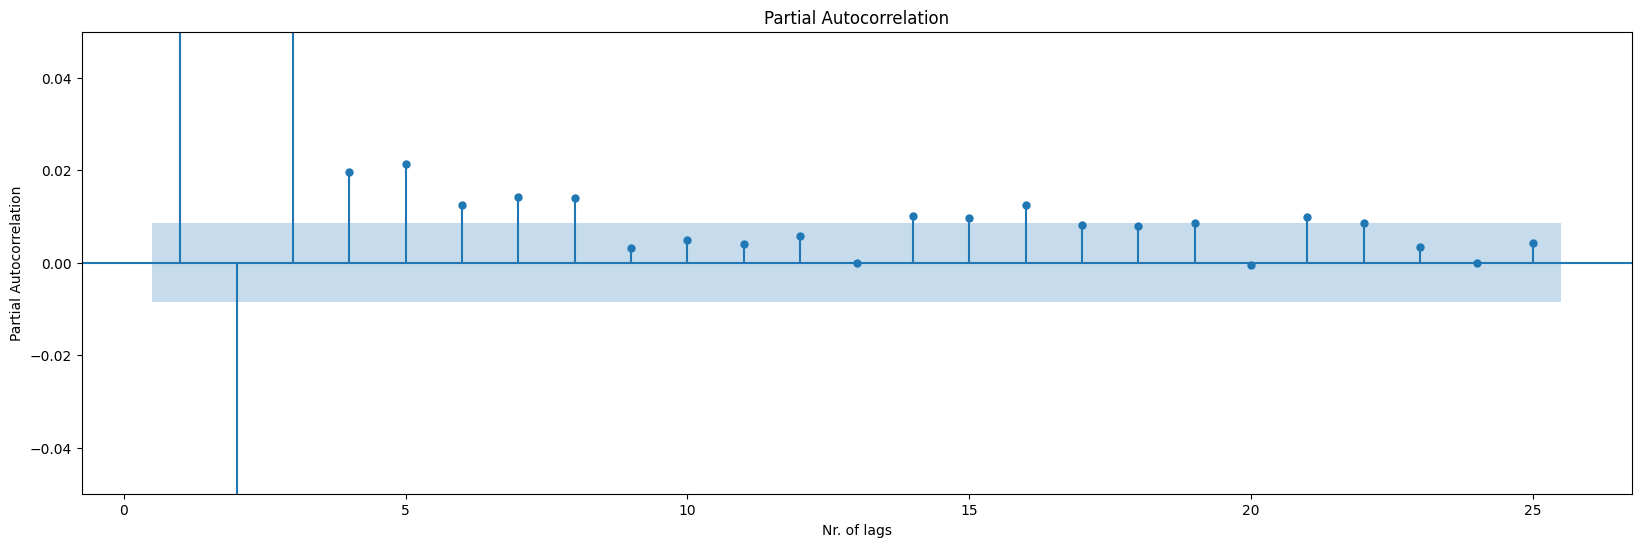

In [387]:
# plot autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams['figure.figsize'] = (20,6)
plot_pacf(df_re['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Partial Autocorrelation')
plt.ylim(-0.05, 0.05)

In [388]:
from statsmodels.tsa.stattools import pacf
re_pacf = pacf(x=df_re['remainder'], nlags=26) #alpha=.05, 95 % confidence intervals
re_pacf

array([ 1.00000000e+00,  8.03050620e-01, -1.36216380e-01,  7.90452173e-02,
        1.97014428e-02,  2.14729238e-02,  1.24040147e-02,  1.41338529e-02,
        1.40975840e-02,  3.18254698e-03,  4.85936736e-03,  3.94772004e-03,
        5.74916179e-03, -1.07762424e-04,  1.01576676e-02,  9.57334384e-03,
        1.24183756e-02,  8.24744578e-03,  7.97654253e-03,  8.52856676e-03,
       -5.99620925e-04,  9.95209062e-03,  8.58292467e-03,  3.41829819e-03,
       -7.09965477e-05,  4.29922335e-03,  3.01730900e-03])

In [389]:
from statsmodels.tsa.ar_model import ar_select_order
mod = ar_select_order(df_re['remainder'], maxlag=25)
mod.ar_lags

[1, 2, 3, 4, 5]

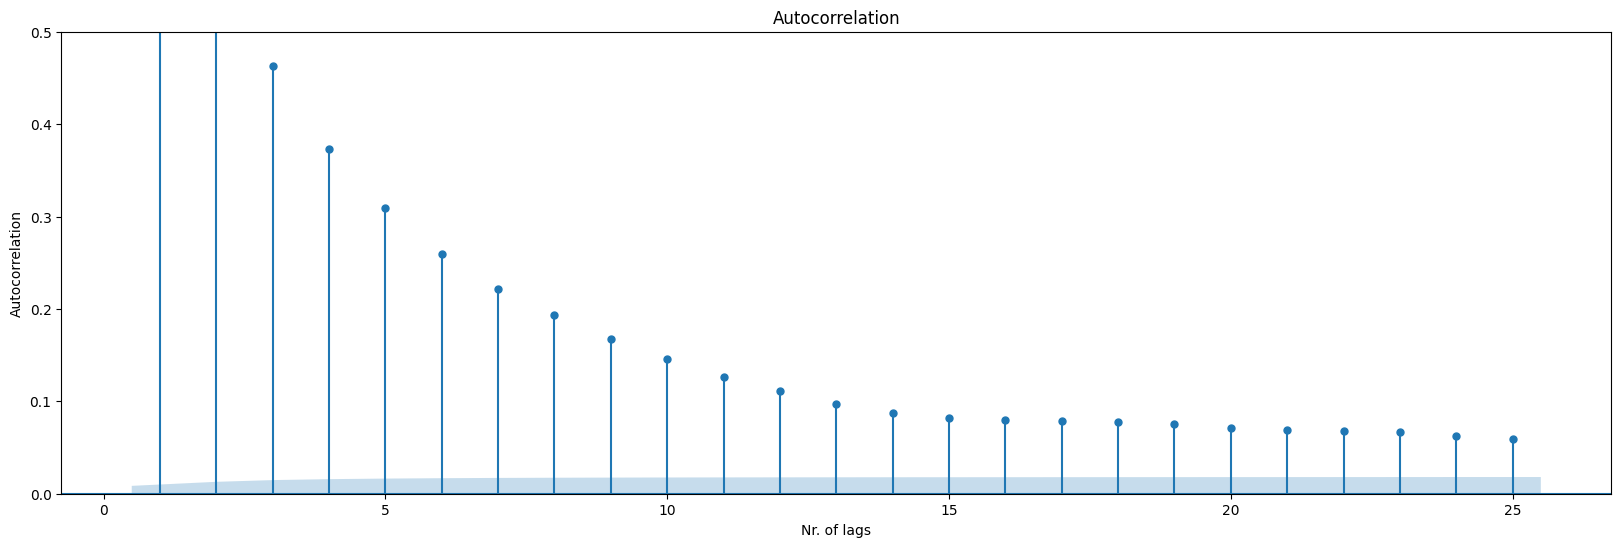

In [390]:
# plot autocorrelation function
plt.rcParams['figure.figsize'] = (20,6)
plot_acf(df_re['remainder'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
plt.ylim(0, 0.5)
None

In [391]:
from statsmodels.tsa.stattools import acf
re_acf = acf(x=df_re['remainder'], nlags=26)
re_acf

array([1.        , 0.80303546, 0.59649601, 0.46242099, 0.37292798,
       0.30881487, 0.25948167, 0.22150223, 0.19289418, 0.16780575,
       0.14563008, 0.12667153, 0.1114362 , 0.09746424, 0.08783826,
       0.08231734, 0.08019138, 0.07878223, 0.07715365, 0.07575877,
       0.07166472, 0.06892325, 0.06815222, 0.06654842, 0.06266041,
       0.05890759, 0.05575516])

In [392]:
# maximum interval to consider
p = 5
lags = [i+1 for i in range(p)]

for lag in lags:
    column_name = 'lag' + str(lag)
    df_train[column_name] = df_train['remainder'].shift(lag)

In [393]:
df_train.head()

TEMP  timestep     trend   no_trend  day_of_year_sin  \
DATE                                                               
1876-01-01   2.2         0  8.527227  -6.327227         0.017213   
1876-01-02   2.5         1  8.527260  -6.027260         0.034422   
1876-01-03   0.3         2  8.527294  -8.227294         0.051620   
1876-01-04  -5.8         3  8.527327 -14.327327         0.068802   
1876-01-05  -9.8         4  8.527360 -18.327360         0.085965   

            day_of_year_cos  trend_seasonal_day  month_sin  month_cos  \
DATE                                                                    
1876-01-01         0.999852           -0.810634        0.5   0.866025   
1876-01-02         0.999407           -0.855106        0.5   0.866025   
1876-01-03         0.998667           -0.896792        0.5   0.866025   
1876-01-04         0.997630           -0.935677        0.5   0.866025   
1876-01-05         0.996298           -0.971751        0.5   0.866025   

            trend_seasonal_month  remainder      lag1      lag2      lag3  \
DATE                                                                        
1876-01-01             -1.114660   3.010634       NaN       NaN       NaN   
1876-01-02             -1.114627   3.355106  3.010634       NaN       NaN   
1876-01-03             -1.114594   1.196792  3.355106  3.010634       NaN   
1876-01-04             -1.114562  -4.864323  1.196792  3.355106  3.010634   
1876-01-05             -1.114529  -8.828249 -4.864323  1.196792  3.355106   

                lag4  lag5  
DATE                        
1876-01-01       NaN   NaN  
1876-01-02       NaN   NaN  
1876-01-03       NaN   NaN  
1876-01-04       NaN   NaN  
1876-01-05  3.010634   NaN

In [394]:
df_train.dropna(inplace=True)
df_train.head()

TEMP  timestep     trend   no_trend  day_of_year_sin  \
DATE                                                               
1876-01-06  -7.7         5  8.527394 -16.227394         0.103102   
1876-01-07  -6.6         6  8.527427 -15.127427         0.120208   
1876-01-08  -8.9         7  8.527460 -17.427460         0.137279   
1876-01-09 -12.7         8  8.527494 -21.227494         0.154309   
1876-01-10  -8.9         9  8.527527 -17.427527         0.171293   

            day_of_year_cos  trend_seasonal_day  month_sin  month_cos  \
DATE                                                                    
1876-01-06         0.994671           -1.005004        0.5   0.866025   
1876-01-07         0.992749           -1.035424        0.5   0.866025   
1876-01-08         0.990532           -1.063004        0.5   0.866025   
1876-01-09         0.988023           -1.087735        0.5   0.866025   
1876-01-10         0.985220           -1.109610        0.5   0.866025   

            trend_seasonal_month  remainder       lag1      lag2      lag3  \
DATE                                                                         
1876-01-06             -1.114496  -6.694996  -8.828249 -4.864323  1.196792   
1876-01-07             -1.114464  -5.564576  -6.694996 -8.828249 -4.864323   
1876-01-08             -1.114431  -7.836996  -5.564576 -6.694996 -8.828249   
1876-01-09             -1.114398 -11.612265  -7.836996 -5.564576 -6.694996   
1876-01-10             -1.114366  -7.790390 -11.612265 -7.836996 -5.564576   

                lag4      lag5  
DATE                            
1876-01-06  3.355106  3.010634  
1876-01-07  1.196792  3.355106  
1876-01-08 -4.864323  1.196792  
1876-01-09 -8.828249 -4.864323  
1876-01-10 -6.694996 -8.828249

In [395]:
# feature and target for autoregression model
X_remainder = df_train[['lag1', 'lag2', 'lag3', 'lag4','lag5']]
y_remainder = df_train['remainder']

In [396]:
# model for remainder
m_ar = LinearRegression()
m_ar.fit(X_remainder,y_remainder)

LinearRegression()

In [397]:
# prediction

df_train['ar_predictions'] = m_ar.predict(X_remainder)

<AxesSubplot: xlabel='DATE'>

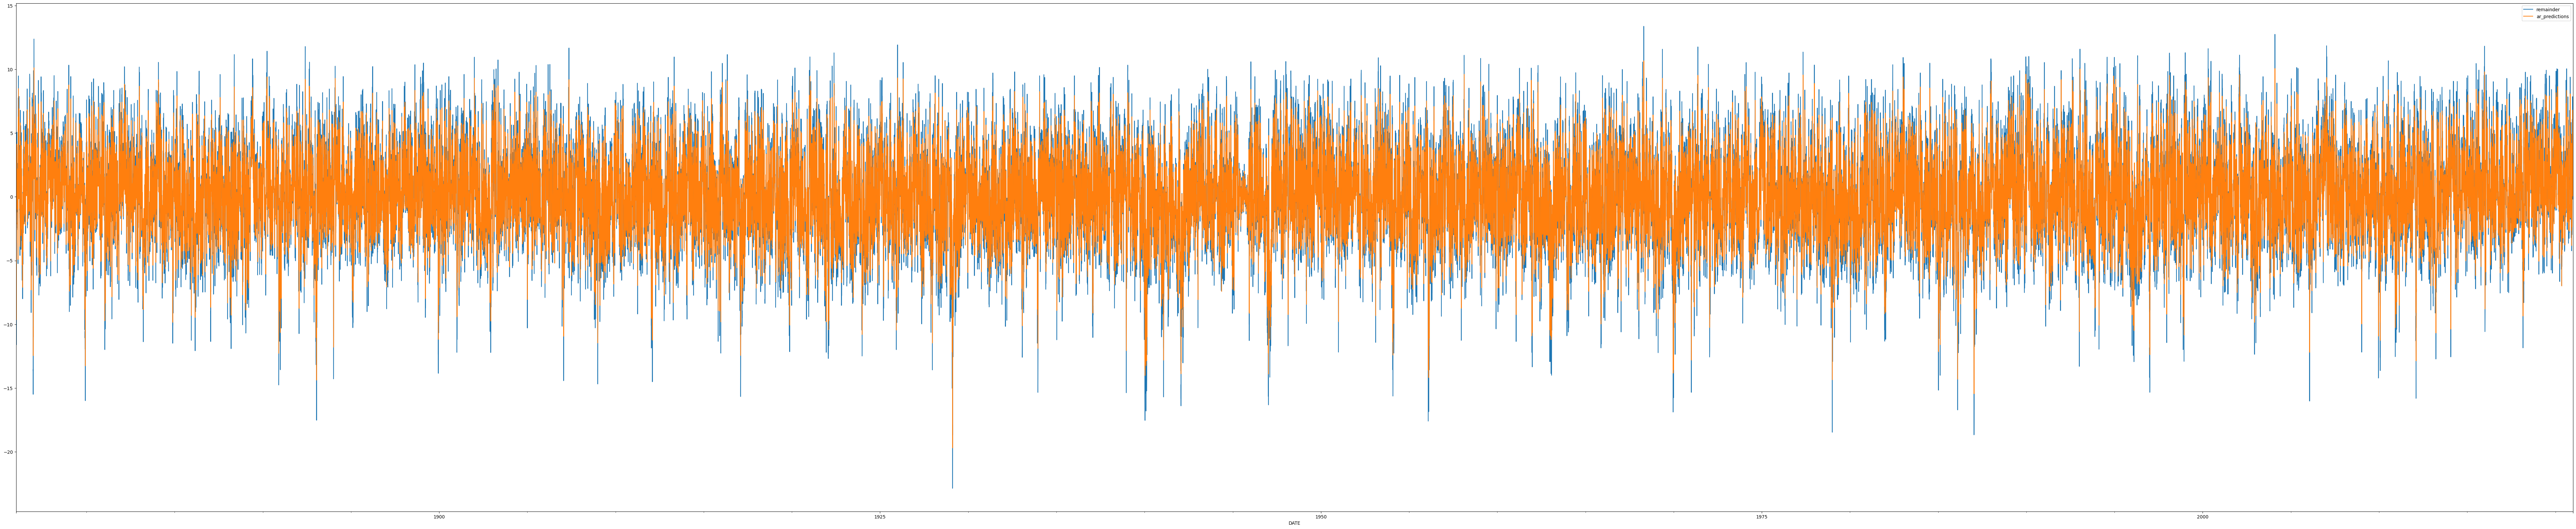

In [398]:
# Plot original remainder and prediction

df_train[['remainder','ar_predictions']].plot(figsize=(100,20),legend=True)

<AxesSubplot: xlabel='DATE'>

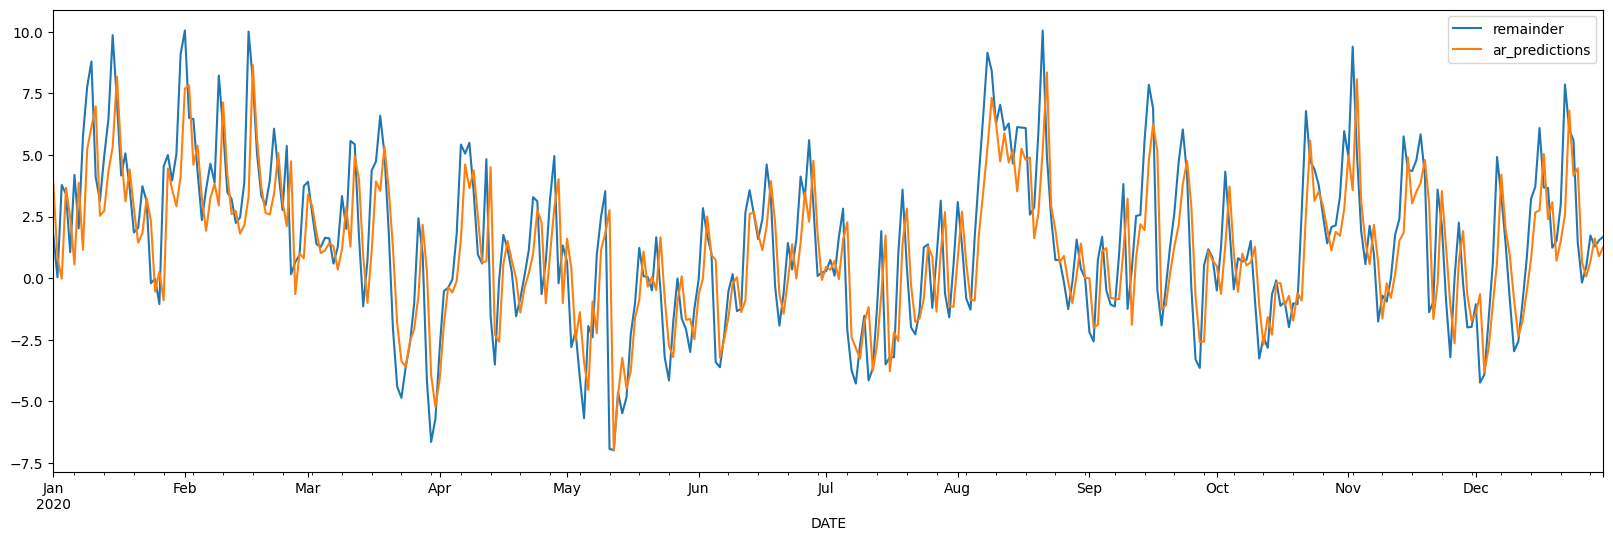

In [399]:
df_train['2020-01-01':'2020-12-31'][['remainder','ar_predictions']].plot(figsize=(20,6),legend=True)

### Check residual

In [400]:
# residual noise

df_train['residuals_ar'] = df_train['remainder'] - df_train['ar_predictions']

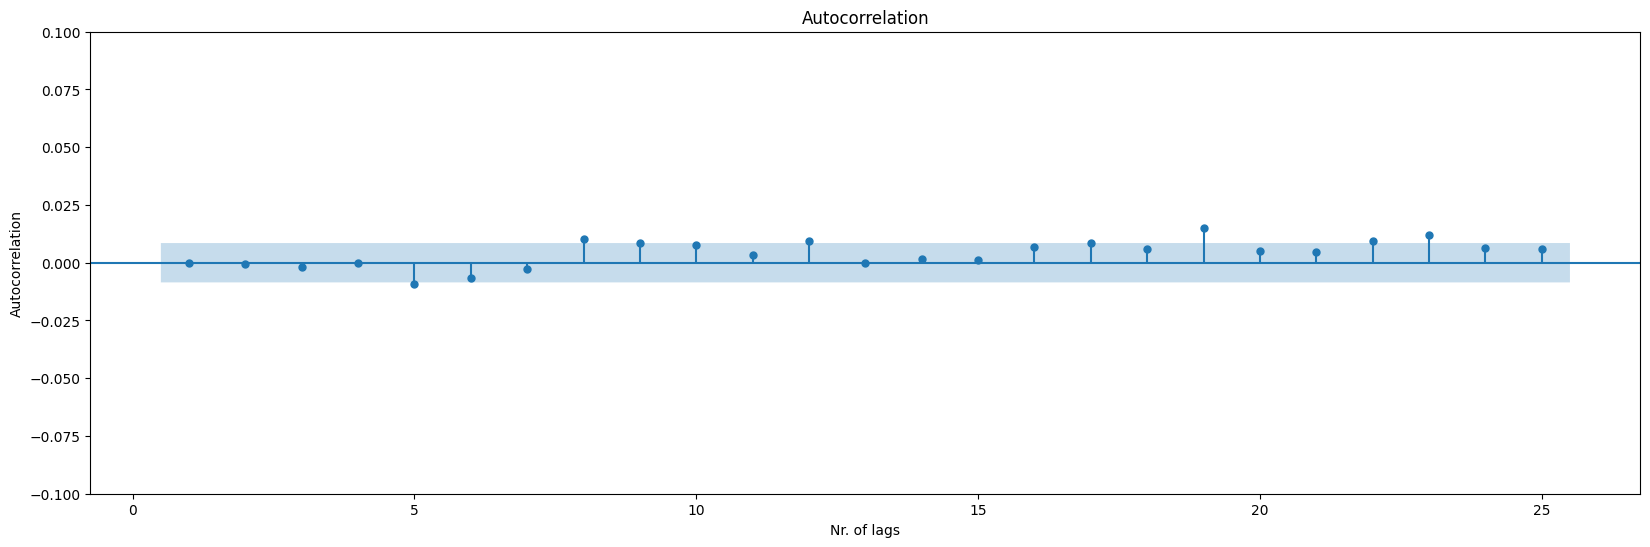

In [401]:
# plot autocorrelation function

plot_acf(df_train['residuals_ar'],zero=False,lags=25)
plt.xlabel('Nr. of lags')
plt.ylabel('Autocorrelation')
plt.ylim(-0.1, 0.1)
None

## 7. Run the full model

In [402]:
df_train.columns

Index(['TEMP', 'timestep', 'trend', 'no_trend', 'day_of_year_sin',
       'day_of_year_cos', 'trend_seasonal_day', 'month_sin', 'month_cos',
       'trend_seasonal_month', 'remainder', 'lag1', 'lag2', 'lag3', 'lag4',
       'lag5', 'ar_predictions', 'residuals_ar'],
      dtype='object')

In [403]:
X_full = df_train[['timestep', 'day_of_year_sin', 'day_of_year_cos', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5']]
y_full = df_train['TEMP']

In [404]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [405]:
df_train['pred_full_model'] = m_full.predict(X_full)

# ----------------- df_train_full.csv -----------------

In [406]:
df_train.to_csv('df_train_full.csv') 

### Comparision

<AxesSubplot: xlabel='DATE'>

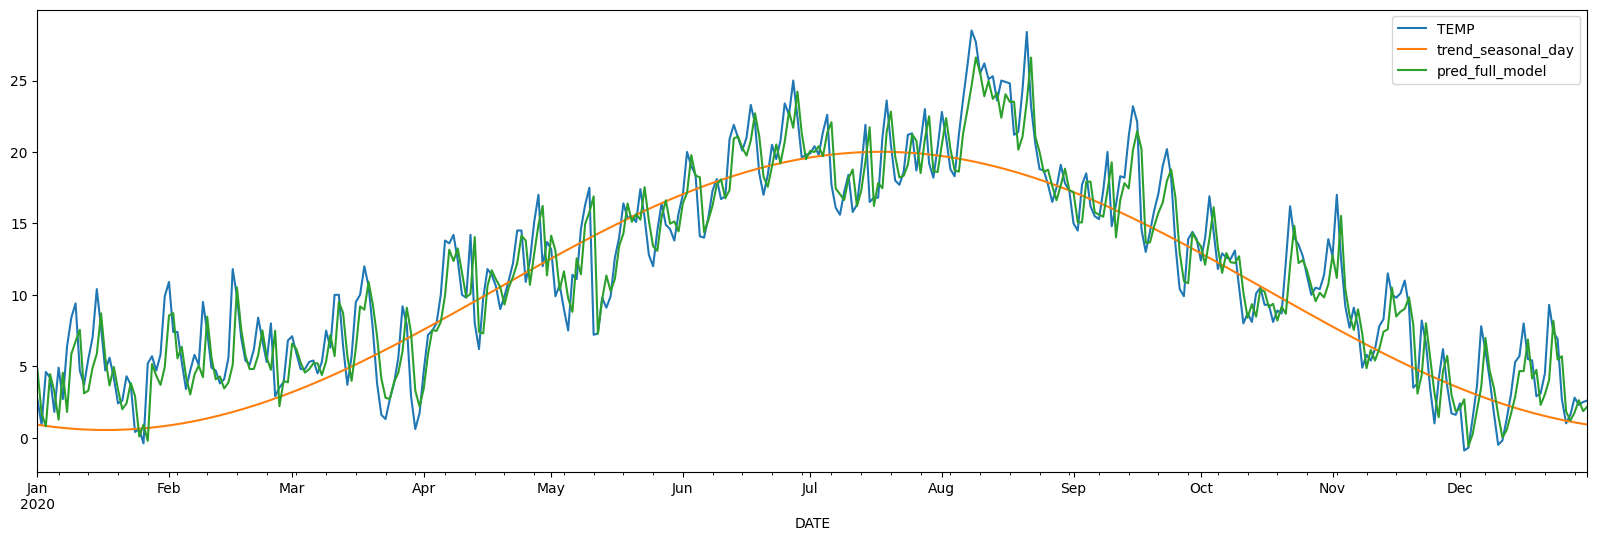

In [407]:
df_train['2020-01-01':'2020-12-31'][['TEMP','trend_seasonal_day', 'pred_full_model']].plot(figsize=(20,6),legend=True)

### Evaluation

In [180]:
X_full.head()

timestep  day_of_year_sin  day_of_year_cos       lag1      lag2  \
DATE                                                                          
1876-01-06         5         0.103102         0.994671  -8.828249 -4.864323   
1876-01-07         6         0.120208         0.992749  -6.694996 -8.828249   
1876-01-08         7         0.137279         0.990532  -5.564576 -6.694996   
1876-01-09         8         0.154309         0.988023  -7.836996 -5.564576   
1876-01-10         9         0.171293         0.985220 -11.612265 -7.836996   

                lag3      lag4      lag5  
DATE                                      
1876-01-06  1.196792  3.355106  3.010634  
1876-01-07 -4.864323  1.196792  3.355106  
1876-01-08 -8.828249 -4.864323  1.196792  
1876-01-09 -6.694996 -8.828249 -4.864323  
1876-01-10 -5.564576 -6.694996 -8.828249

In [181]:
# Model Evaluation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [182]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [183]:
# Do the cross validation: Remember these are the 'test scores' in the training data.
result = cross_val_score(estimator=m_full, 
                         X=X_full, y=y_full,
                         cv=time_series_split
                       )
result

array([0.9114086 , 0.91845877, 0.91988753, 0.91372779, 0.92460877])

## 8. Test model

In [408]:
clean_temp = pd.read_csv('clean_temp.csv', parse_dates=True, index_col=0)
df_test = clean_temp[clean_temp.index >= pd.Timestamp(2021,1,1)]


In [409]:
X_full.columns

Index(['timestep', 'day_of_year_sin', 'day_of_year_cos', 'lag1', 'lag2',
       'lag3', 'lag4', 'lag5'],
      dtype='object')

In [410]:
df_test.columns

Index(['TEMP'], dtype='object')

In [411]:
# Get the first timestep for test from the last timestep of the training data
start_test_timestep = X_full['timestep'][-1] + 1
df_test['timestep'] = range(start_test_timestep, start_test_timestep+len(df_test))
df_test.columns

Index(['TEMP', 'timestep'], dtype='object')

In [412]:
# add seasonality
df_test['day_of_year_sin'] = np.sin(2 * np.pi * df_test.index.day_of_year/365.0)
df_test['day_of_year_cos'] = np.cos(2 * np.pi * df_test.index.day_of_year/365.0)
df_test.columns

Index(['TEMP', 'timestep', 'day_of_year_sin', 'day_of_year_cos'], dtype='object')

In [413]:
X_test_ts = df_test.drop(['TEMP'], axis=1)
X_test_ts.columns

Index(['timestep', 'day_of_year_sin', 'day_of_year_cos'], dtype='object')

In [414]:
df_test['trend_seasonal_day'] = m_trend_seasonal_day.predict(X_test_ts)

In [415]:
df_test['remainder'] = df_test['TEMP'] - df_test['trend_seasonal_day']
df_test.columns

Index(['TEMP', 'timestep', 'day_of_year_sin', 'day_of_year_cos',
       'trend_seasonal_day', 'remainder'],
      dtype='object')

In [416]:
# maximum interval to consider
p = 5
lags = [i+1 for i in range(p)]

for lag in lags:
    column_name = 'lag' + str(lag)
    df_test[column_name] = df_test['remainder'].shift(lag)

In [417]:
df_test.head(6)

TEMP  timestep  day_of_year_sin  day_of_year_cos  \
DATE                                                           
2021-01-01   2.1     52961         0.017213         0.999852   
2021-01-02   1.1     52962         0.034422         0.999407   
2021-01-03   0.6     52963         0.051620         0.998667   
2021-01-04   0.8     52964         0.068802         0.997630   
2021-01-05   1.7     52965         0.085965         0.996298   
2021-01-06   2.0     52966         0.103102         0.994671   

            trend_seasonal_day  remainder      lag1      lag2      lag3  \
DATE                                                                      
2021-01-01            0.920503   1.179497       NaN       NaN       NaN   
2021-01-02            0.876031   0.223969  1.179497       NaN       NaN   
2021-01-03            0.834345  -0.234345  0.223969  1.179497       NaN   
2021-01-04            0.795460   0.004540 -0.234345  0.223969  1.179497   
2021-01-05            0.759386   0.940614  0.004540 -0.234345  0.223969   
2021-01-06            0.726133   1.273867  0.940614  0.004540 -0.234345   

                lag4      lag5  
DATE                            
2021-01-01       NaN       NaN  
2021-01-02       NaN       NaN  
2021-01-03       NaN       NaN  
2021-01-04       NaN       NaN  
2021-01-05  1.179497       NaN  
2021-01-06  0.223969  1.179497

### fill out nan value

In [418]:
p = 5
rows = [i for i in range(p)]
for row in rows:   # go through rows according p value 
   # fill out lag columns for each row     
   n = -1
   for lag in range(row, p):
       column_name = "lag" + str(lag+1)
    #  print("row" + str(row), "lag" + str(lag+1), n)
       df_test.loc[df_test.index[row], column_name] = df_train.loc[df_train.index[n], 'remainder']
       n = n-1


In [419]:
df_train = pd.read_csv('df_train_full.csv', index_col=1, parse_dates=True)
df_train['remainder'].tail(5)

TEMP
1.6    0.474043
2.8    1.729525
2.3    1.282277
2.5    1.532283
2.6    1.679530
Name: remainder, dtype: float64

In [420]:
df_test.head(6)

TEMP  timestep  day_of_year_sin  day_of_year_cos  \
DATE                                                           
2021-01-01   2.1     52961         0.017213         0.999852   
2021-01-02   1.1     52962         0.034422         0.999407   
2021-01-03   0.6     52963         0.051620         0.998667   
2021-01-04   0.8     52964         0.068802         0.997630   
2021-01-05   1.7     52965         0.085965         0.996298   
2021-01-06   2.0     52966         0.103102         0.994671   

            trend_seasonal_day  remainder      lag1      lag2      lag3  \
DATE                                                                      
2021-01-01            0.920503   1.179497  1.679530  1.532283  1.282277   
2021-01-02            0.876031   0.223969  1.179497  1.679530  1.532283   
2021-01-03            0.834345  -0.234345  0.223969  1.179497  1.679530   
2021-01-04            0.795460   0.004540 -0.234345  0.223969  1.179497   
2021-01-05            0.759386   0.940614  0.004540 -0.234345  0.223969   
2021-01-06            0.726133   1.273867  0.940614  0.004540 -0.234345   

                lag4      lag5  
DATE                            
2021-01-01  1.729525  0.474043  
2021-01-02  1.282277  1.729525  
2021-01-03  1.532283  1.282277  
2021-01-04  1.679530  1.532283  
2021-01-05  1.179497  1.679530  
2021-01-06  0.223969  1.179497

In [421]:
y_test = df[['TEMP']]
X_test_full = df_test.drop(['TEMP','trend_seasonal_day','remainder'], axis=1)
X_test_full.columns

Index(['timestep', 'day_of_year_sin', 'day_of_year_cos', 'lag1', 'lag2',
       'lag3', 'lag4', 'lag5'],
      dtype='object')

In [422]:
# Create the predictions
df_test['pred_full_model'] = m_full.predict(X_test_full)

In [423]:
df_test.to_csv('df_test_full.csv')

# ----------------- df_test_full.csv -----------------

<AxesSubplot: xlabel='DATE'>

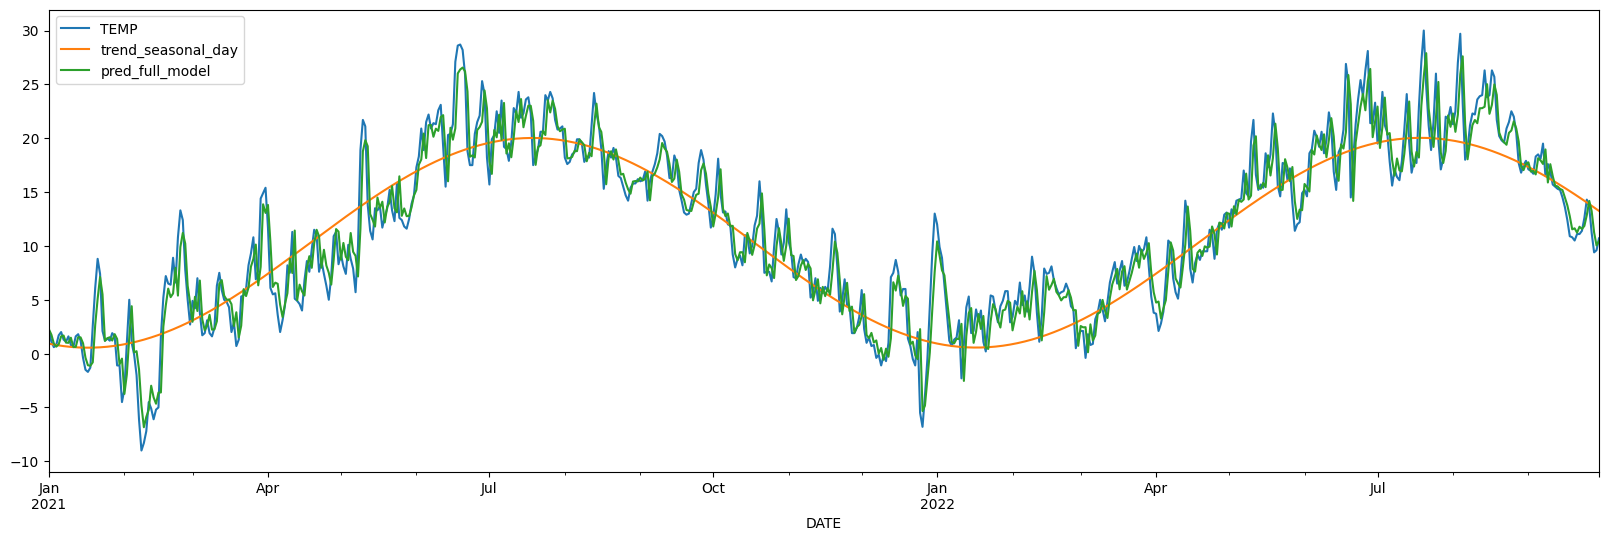

In [199]:
# comparision
df_test[['TEMP','trend_seasonal_day', 'pred_full_model']].plot(figsize=(20,6),legend=True)

In [200]:
print(f"""
{m_full.score(X_test_full, df_test['TEMP'])}
{m_trend_seasonal_day.score(X_test_ts, df_test['TEMP'])}
""")


0.9301852134632415
0.8004210078465486



## 9. Build new model with full data (train + test dataset)

In [439]:
df_train = pd.read_csv('df_train_full.csv',index_col=0, parse_dates=True)
df_train.tail(2)

TEMP  timestep      trend  no_trend  day_of_year_sin  \
DATE                                                               
2020-12-30   2.5     52959  10.293460 -7.793460     6.432491e-16   
2020-12-31   2.6     52960  10.293493 -7.693493     1.721336e-02   

            day_of_year_cos  trend_seasonal_day     month_sin  month_cos  \
DATE                                                                       
2020-12-30         1.000000            0.967717 -2.449294e-16        1.0   
2020-12-31         0.999852            0.920470 -2.449294e-16        1.0   

            trend_seasonal_month  remainder      lag1      lag2      lag3  \
DATE                                                                        
2020-12-30              2.080967   1.532283  1.282277  1.729525  0.474043   
2020-12-31              2.081000   1.679530  1.532283  1.282277  1.729525   

                lag4      lag5  ar_predictions  residuals_ar  pred_full_model  
DATE                                                                           
2020-12-30 -0.184152  1.454958        0.888146      0.644137         1.855845  
2020-12-31  0.474043 -0.184152        1.257037      0.422493         2.177490

In [440]:
df_test = pd.read_csv('df_test_full.csv',index_col=0, parse_dates=True)
df_test.head(2)

TEMP  timestep  day_of_year_sin  day_of_year_cos  \
DATE                                                           
2021-01-01   2.1     52961         0.017213         0.999852   
2021-01-02   1.1     52962         0.034422         0.999407   

            trend_seasonal_day  remainder      lag1      lag2      lag3  \
DATE                                                                      
2021-01-01            0.920503   1.179497  1.679530  1.532283  1.282277   
2021-01-02            0.876031   0.223969  1.179497  1.679530  1.532283   

                lag4      lag5  pred_full_model  
DATE                                             
2021-01-01  1.729525  0.474043         2.246606  
2021-01-02  1.282277  1.729525         1.754591

In [441]:
df_combined_1 = df_train[['TEMP','timestep', 'day_of_year_sin', 'day_of_year_cos', 'remainder', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5']]
df_combined_2 = df_test[['TEMP','timestep', 'day_of_year_sin', 'day_of_year_cos', 'remainder', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5']]
df_combined = df_combined_1.append(df_combined_2)
df_combined.head(2)


TEMP  timestep  day_of_year_sin  day_of_year_cos  remainder  \
DATE                                                                      
1876-01-06  -7.7         5         0.103102         0.994671  -6.694996   
1876-01-07  -6.6         6         0.120208         0.992749  -5.564576   

                lag1      lag2      lag3      lag4      lag5  
DATE                                                          
1876-01-06 -8.828249 -4.864323  1.196792  3.355106  3.010634  
1876-01-07 -6.694996 -8.828249 -4.864323  1.196792  3.355106

In [442]:
X_combined = df_combined.drop(['TEMP', 'remainder'], axis=1)
y_combined = df_combined['TEMP']

In [443]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [464]:
import pickle
with open('model_combined.pkl', 'wb') as pkl:
    pickle.dump(m_combined, pkl)

In [444]:
print(f"""
{m_combined.score(X_combined, y_combined)}
""")


0.9200859235878229



## calculate AIC

In [466]:
#define response variable
y = y_combined

#define predictor variables
x = X_combined

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

#view AIC of model
print(model.aic)

237931.67505473568


## 10. Predict the future
### make future data - one day later

In [446]:
# last day of current data
final_day = df_combined.index[-1]

In [447]:
# future day
future_date = final_day + pd.DateOffset(days=1)

In [448]:
import datetime
import pandas as pd

index = pd.date_range(future_date, periods=2, freq='D')
columns =  X_combined.columns.tolist()
df_future = pd.DataFrame(np.nan, index=index, columns=columns)
print(df_future)

            timestep  day_of_year_sin  day_of_year_cos  lag1  lag2  lag3  \
2022-10-01       NaN              NaN              NaN   NaN   NaN   NaN   
2022-10-02       NaN              NaN              NaN   NaN   NaN   NaN   

            lag4  lag5  
2022-10-01   NaN   NaN  
2022-10-02   NaN   NaN  


In [449]:
df_future.index[0]

Timestamp('2022-10-01 00:00:00', freq='D')

In [450]:
df_future.iloc[0]['timestep'] = df_combined['timestep'].max() + 1

In [451]:
df_future.iloc[0]['day_of_year_sin'] = np.sin(2 * np.pi * df_future.index[0].day_of_year/365.0)
df_future.iloc[0]['day_of_year_cos'] = np.cos(2 * np.pi * df_future.index[0].day_of_year/365.0)

In [452]:
p = 5
row = 0
n = -1
for lag in range(row, p):
    column_name = "lag" + str(lag+1)
    # print("row" + str(row), "lag" + str(lag+1), n)
    df_future.iloc[row][column_name] = df_combined.iloc[n]['remainder']
    n = n-1

In [453]:
df_future

timestep  day_of_year_sin  day_of_year_cos     lag1      lag2  \
2022-10-01   53599.0        -0.999991         0.004304 -2.54998 -3.809203   
2022-10-02       NaN              NaN              NaN      NaN       NaN   

                lag3      lag4      lag5  
2022-10-01 -4.167506 -2.524842 -0.281163  
2022-10-02       NaN       NaN       NaN

In [454]:
df_combined.tail(5)['remainder']

DATE
2022-09-26   -0.281163
2022-09-27   -2.524842
2022-09-28   -4.167506
2022-09-29   -3.809203
2022-09-30   -2.549980
Name: remainder, dtype: float64

In [455]:
X_future_1 = df_future.iloc[0].to_frame().transpose()

In [456]:
# Prediction for 2022-10-01
m_combined.predict(X_future_1)

array([11.25572979])

### make future data - two days later

In [457]:
df_future.iloc[1]['timestep'] = df_combined['timestep'].max() + 2
df_future.iloc[1]['day_of_year_sin'] = np.sin(2 * np.pi * df_future.index[1].day_of_year/365.0)
df_future.iloc[1]['day_of_year_cos'] = np.cos(2 * np.pi * df_future.index[1].day_of_year/365.0)

In [458]:
p = 5
row = 1
n = -1
for lag in range(row, p):
    column_name = "lag" + str(lag+1)
    # print("row" + str(row), "lag" + str(lag+1), n)
    df_future.iloc[row][column_name] = df_combined.iloc[n]['remainder']
    n = n-1

In [461]:
df_future.fillna(0, inplace=True)

In [465]:
df_future.to_csv('df_future.csv')
df_future

timestep  day_of_year_sin  day_of_year_cos     lag1      lag2  \
2022-10-01   53599.0        -0.999991         0.004304 -2.54998 -3.809203   
2022-10-02   53600.0        -0.999769         0.021516  0.00000 -2.549980   

                lag3      lag4      lag5  
2022-10-01 -4.167506 -2.524842 -0.281163  
2022-10-02 -3.809203 -4.167506 -2.524842

In [462]:
X_future_2 = df_future.iloc[1].to_frame().transpose()

In [463]:
# Prediction for 2022-10-02
m_combined.predict(X_future_2)

array([13.16078932])